In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import boxcox

In [15]:
def cusum(
    x,
    threshold=1,
    parameter="mean",
    drift=1,
    T_warmup=1000,
    zscore=True,
    mean=None,
    std=None,
    cusum_type="reset",
    upper_limit=None,
):
    """CUSUM Control Chart

    Parameters
    ----------
    x : np.array (Time, features)
        Time series to run CUSUM on
    threshold : float
        Number of std upper and lower cumulative sums are
         allowed to drift from the mean before CUSUM detects change
    parameter : str ('mean' or 'std')
        The distribution parameter to measure. Currently only mean is implemented.
    nshift : float
        Number of std to allow drift from the mean at each time point
    T_warmup : int
        Number of time points to use to estimate the mean and std
    zscore : bool
        Whether to zscore the data before running CUSUM. If so, then use
        0 as mean and 1 as std.
    std : float, list[floats]
        Standard deviation of the data to use (good std)
    mean : float, list[floats]
        Mean of the data to use (good mean)
    cusum_type : str
        "reset": reset the CUSUM when it exceeds the threshold
        "limit": limit the CUSUM to the threshold (no reset)
        "no limit": no limit on the CUSUM and no reset
    upper_limit : float
        Upper limit of the CUSUM to threshold at. Defined as
         number of std away from mean. Only used when cusum_type="limit"
    """
    if zscore:
        mean = np.mean(x[:T_warmup], dim=0, keepdims=True)
        std = np.std(x[:T_warmup], dim=0, keepdims=True)
        z = (x - mean) / std
        print("Z score data, set mean=0 and std=1")
    else:
        z = x.copy()
    if isinstance(mean, float) or isinstance(mean, int):
        mean = np.ones(x.shape[1]) * mean * 1.0
    if isinstance(std, float) or isinstance(std, int):
        std = np.ones(x.shape[1]) * std * 1.0
    if mean is None:
        mean = np.zeros(x.shape[1])
    if std is None:
        std = np.ones(x.shape[1])

    S_upper = np.zeros_like(z)
    S_lower = np.zeros_like(x)
    for i in range(1, len(z)):
        if parameter == "mean":
            if cusum_type == "reset":
                S_upper_prev = _reset_cusum(
                    S_upper[i - 1], threshold=threshold, std=std
                )
                S_lower_prev = _reset_cusum(
                    S_lower[i - 1], threshold=threshold, std=std
                )
            elif cusum_type == "limit":
                S_upper_prev = np.minimum(S_upper[i - 1], upper_limit * std)
                S_lower_prev = np.maximum(S_lower[i - 1], -upper_limit * std)
            elif cusum_type == "no limit":
                S_upper_prev = S_upper[i - 1]
                S_lower_prev = S_lower[i - 1]

            S_upper[i] = max_upper_cusum(
                z[i], S_upper_prev, mean=mean, std=std, drift=drift
            )
            S_lower[i] = max_lower_cusum(
                z[i], S_lower_prev, mean=mean, std=std, drift=drift
            )

        # elif parameter == 'std':
        #     S[i] = max_upper_cusum(z[i], S[i-1], mean=0, std=1, nshift=nshift)
        else:
            raise ValueError("parameter must be 'mean' or 'std'")

    upper_changepoint_indices = np.where(S_upper > threshold * std)
    lower_changepoint_indices = np.where(S_lower < -threshold * std)
    return upper_changepoint_indices, lower_changepoint_indices, S_upper, S_lower


def max_upper_cusum(x, s, mean=0, std=1, drift=1):
    """Upper CUSUM Control Chart max function
    x: data point
    s: previous CUSUM value
    """

    u = np.maximum(np.zeros_like(x), s + x - mean - std * drift)
    return u


def max_lower_cusum(x, s, mean=0, std=1, drift=1):
    """Lower CUSUM Control Chart max function
    x: data point
    s: previous CUSUM value
    """

    l = np.minimum(np.zeros_like(x), s + x - mean + std * drift)
    return l


def _reset_cusum(s, threshold=1, std=1):
    """Reset CUSUM Control Chart
    s: previous CUSUM value
    """
    if np.any(s > threshold * std):
        s = s.copy()
        s[np.abs(s) > threshold * std] = 0
    return s

In [4]:
DATA_DIR = "../OFC_data/"
IMG_DIR = "./images/EC125"
os.makedirs(IMG_DIR, exist_ok=True)
fn = "v7_EC125_TimeAveragedSpectraPower_6mA_FreqBands.pkl"
patient = fn.split("_")[1]
current = [i for i in fn.split("_") if "mA" in i][0]
savefig = False
patient, current

('EC125', '6mA')

In [5]:
with open(f"{DATA_DIR}/{fn}", "rb") as f:
    data_dict = np.load(f, allow_pickle=True).item()

In [40]:
power = data_dict["power_stim"]
freqs = data_dict["freqs"]
finalVerifiedChanNames = data_dict["finalVerifiedChanNames"]
finalVerifiedRegions = data_dict["finalVerifiedRegions"]
regionNames = data_dict["regionNames"]

print(power.shape)
cutoff_freq = 28
cutoff_idx = np.where(freqs > cutoff_freq)[0][0]
power = power[:, :cutoff_idx]
print(cutoff_idx)
freqs = freqs[:cutoff_idx]
print(power.shape)

(17, 31, 224964)
20
(17, 20, 224964)


In [42]:
finalVerifiedChanNames, finalVerifiedRegions, regionNames

(array(['AOF1', 'AOF4', 'POF2', 'AD2', 'AD3', 'AD4', 'HD2', 'HD3', 'SC3',
        'SC4', 'IC2', 'IC3', 'IND1', 'IND2', 'IND3', 'IND4', 'IND5'],
       dtype='<U4'),
 array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 6], dtype=uint8),
 array(['OFC', 'Amygdala', 'Hippocampus', 'SuperiorCingulate',
        'InferiorCingulate', 'Insula'], dtype='<U17'))

In [7]:
Fs = data_dict["Fs"]
dsFs = data_dict["dsFs"]
# stim_start = int(np.floor(int(1.0 * data_dict["stimStartSample"]) * dsFs / Fs))
# stim_end = int(np.floor(int(1.0 * data_dict["stimEndSample"]) * dsFs / Fs))

stim_start = int(1.0 * data_dict["stimStartSample"])
stim_end = int(1.0 * data_dict["stimEndSample"])

print(stim_start, stim_end)
print(stim_start / dsFs, stim_end / dsFs)

12972 131088
25.3359375 256.03125


In [66]:
region = "SuperiorCingulate"
region_idx = np.where(np.array(regionNames) == region)[0][0] + 1
chan_idx = np.where(np.array(finalVerifiedRegions) == region_idx)[0]
chan_idx, region_idx

(array([8, 9]), 4)

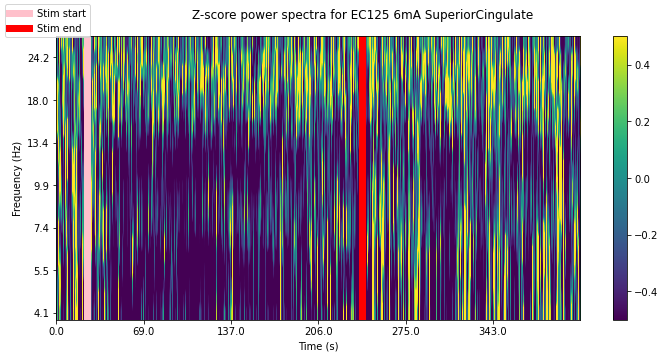

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / Fs * 15 for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

# Plot distribution of powers for each frequency band before, during, after stimulation

In [8]:
data = power[0]
data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(
    data, axis=1, keepdims=True
)
before_stim = data[:, :stim_start]
during_stim = data[:, stim_start:stim_end]
after_stim = data[:, stim_end:]
print(before_stim.shape, during_stim.shape, after_stim.shape)

(20, 12972) (20, 118116) (20, 93876)


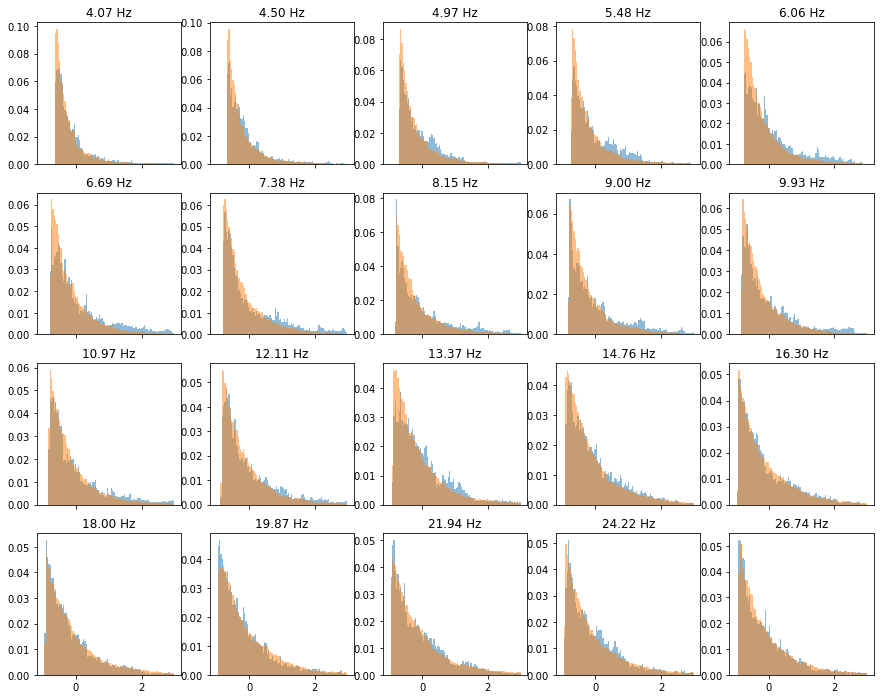

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharex=True)
for i in range(4):
    for j in range(5):
        ind = i * 5 + j
        ax = axes[i, j]
        if ind > 20:
            fig.delaxes(ax)
            continue

        bins = np.linspace(-1.0, 3.0, 100)
        before_weight = np.ones_like(before_stim[ind]) / len(before_stim[ind])
        during_weight = np.ones_like(during_stim[ind]) / len(during_stim[ind])
        # after_weight = np.ones_like(after_stim[ind]) / len(after_stim[ind])

        alpha = 0.5
        weights = [before_weight]
        ax.hist(
            [before_stim[ind]],
            bins=bins,
            weights=weights,
            label=["before"],
            alpha=alpha,
        )
        weights = [during_weight]
        ax.hist(
            [during_stim[ind]],
            bins=bins,
            weights=weights,
            label=["during"],
            alpha=alpha,
        )
        ax.set_title(f"{freqs[ind]:.2f} Hz")

## Log Power

In [79]:
transformed = [boxcox(curr_power) for curr_power in power[0]]
data = np.array([first for (first, second) in transformed])
data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(
    data, axis=1, keepdims=True
)
before_stim = data[:, :stim_start]
during_stim = data[:, stim_start:stim_end]
after_stim = data[:, stim_end:]
print(before_stim.shape, during_stim.shape, after_stim.shape)

(20, 12972) (20, 118116) (20, 93876)


In [80]:
np.max(before_stim), np.min(before_stim), np.max(during_stim), np.min(during_stim)

(3.658501000562249,
 -3.870100975622259,
 3.7169888487433673,
 -4.2799228051546905)

In [81]:
boxcox_lambda = [second for (first, second) in transformed]
boxcox_lambda

[0.13336876340146012,
 0.154846794225839,
 0.16539249929476504,
 0.18443045199998845,
 0.20249459749930698,
 0.20207076169803276,
 0.19235358765153862,
 0.1939954706560901,
 0.19348102487105762,
 0.18864475710333312,
 0.20883898631580883,
 0.20760439450695453,
 0.2266074642969736,
 0.23292127525756529,
 0.23864618069035853,
 0.2324943712507322,
 0.24950464778810047,
 0.2409139674776478,
 0.23560116943171097,
 0.2321721572378443]

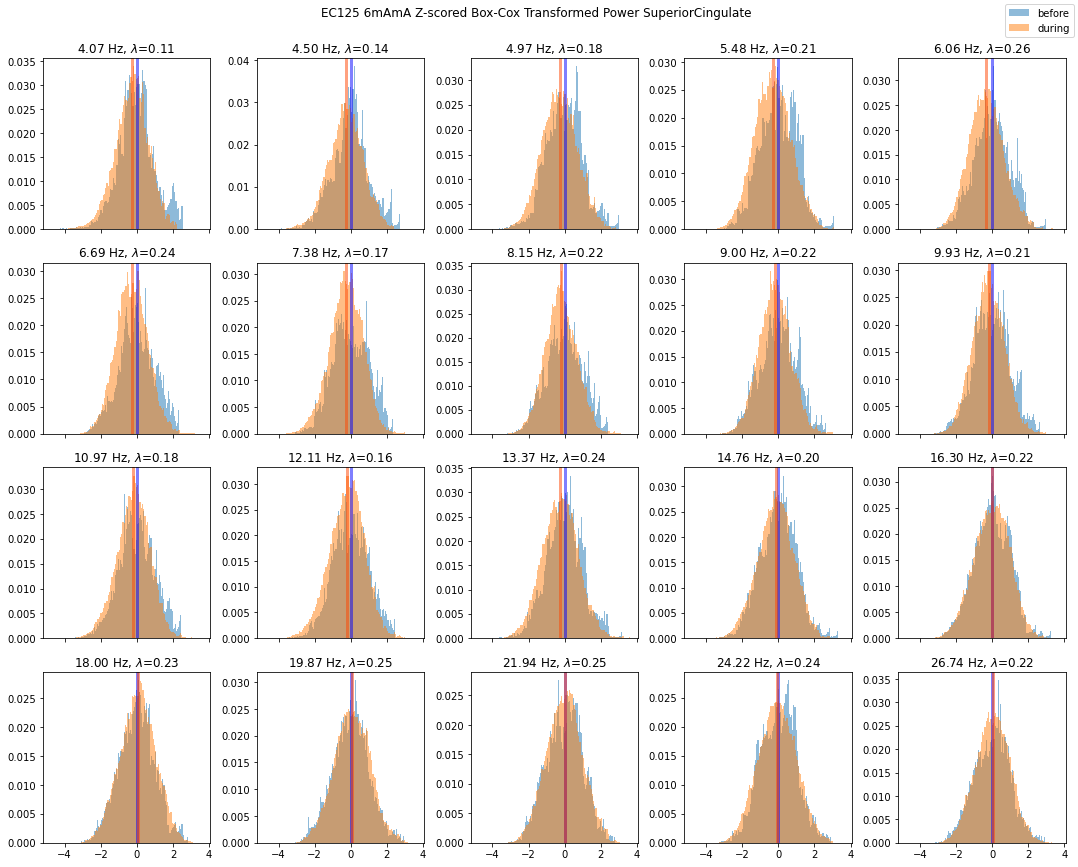

In [103]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharex=True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ind = i * 5 + j
        ax = axes[i, j]
        if ind > 20:
            fig.delaxes(ax)
            continue

        # bins = np.linspace(-3.0, 3.0, 100)
        bins = 100
        before_weight = np.ones_like(before_stim[ind]) / len(before_stim[ind])
        during_weight = np.ones_like(during_stim[ind]) / len(during_stim[ind])
        # after_weight = np.ones_like(after_stim[ind]) / len(after_stim[ind])

        alpha = 0.5
        weights = [before_weight]
        ax.hist(
            [before_stim[ind]],
            bins=bins,
            weights=weights,
            label=["before"],
            alpha=alpha,
        )
        ax.axvline(np.mean(before_stim[ind]), color="blue", lw=3, alpha=alpha)

        weights = [during_weight]
        ax.hist(
            [during_stim[ind]],
            bins=bins,
            weights=weights,
            label=["during"],
            alpha=alpha,
        )
        ax.axvline(np.mean(during_stim[ind]), color="orangered", lw=3, alpha=alpha)
        ax.set_title(rf"{freqs[ind]:.2f} Hz, $\lambda$={boxcox_lambda[ind]:.2f}")

handles, labels = axes[0, 0].get_legend_handles_labels()
remove_dupes = dict(zip(labels, handles))
fig.legend(remove_dupes.values(), remove_dupes.keys())
title = f"{patient} {current}mA Z-scored Box-Cox Transformed Power {region}"
fig.suptitle(title, y=1.0)
fig.tight_layout()
title = title.replace(" ", "_")
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", dpi=300)

# CUSUM on each frequency band

### Get Box-Cox transformation for each frequency based on pre-stimulation data

In [83]:
transformed = [boxcox(curr_power[:stim_start]) for curr_power in power[0]]
boxcox_lambda = [second for (first, second) in transformed]
np.round(boxcox_lambda, 3)

array([0.109, 0.139, 0.181, 0.207, 0.261, 0.245, 0.17 , 0.219, 0.217,
       0.212, 0.185, 0.165, 0.239, 0.198, 0.218, 0.23 , 0.249, 0.246,
       0.244, 0.222])

### Box-Cox transform the data

In [84]:
data = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(power[0])
    ]
)

In [85]:
data = (data - np.mean(data[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data[:, :stim_start], axis=1, keepdims=True
)
data = data.T
print(data.shape)

(224964, 20)


In [86]:
np.mean(data, axis=0)

array([-0.11608113, -0.10357122, -0.11752817, -0.16605726, -0.21049792,
       -0.19060198, -0.16547132, -0.12277809, -0.11877628, -0.13399958,
       -0.12659019, -0.14160749, -0.18346847, -0.11352107,  0.00709075,
        0.0651381 ,  0.07340162,  0.01028415, -0.03966007,  0.04710607])

In [87]:
np.mean(data[:stim_start], axis=0), np.std(data[:stim_start], axis=0), np.mean(
    data[stim_start:stim_end], axis=0
), np.std(data[stim_start:stim_end], axis=0)

(array([ 1.75280354e-16,  1.05168213e-16, -2.62920531e-17,  5.25841063e-17,
         2.45392496e-16, -1.75280354e-17, -2.27864460e-16, -1.05168213e-16,
        -2.97976602e-16, -2.89212584e-16, -2.62920531e-17, -3.50560708e-17,
         1.48988301e-16,  2.14718434e-16,  3.50560708e-17, -7.88761594e-17,
        -2.45392496e-16,  2.36628478e-16,  1.92808390e-16, -2.01572407e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 array([-0.2774926 , -0.26487073, -0.27669545, -0.30953916, -0.32394375,
        -0.27721413, -0.25229598, -0.21285048, -0.20568553, -0.20829775,
        -0.19888995, -0.20658629, -0.23408675, -0.14925436, -0.02650449,
         0.05227802,  0.07941216,  0.00218334, -0.06743065,  0.02484812]),
 array([0.92257498, 0.94349876, 0.97354763, 1.00117877, 0.95307233,
        0.88336225, 0.9112204 , 0.86688993, 0.87051697, 0.87713293,
        0.92249197, 0.9767931 , 0.99669784, 0.98880827, 0.98129972,
        0.98816346, 0.

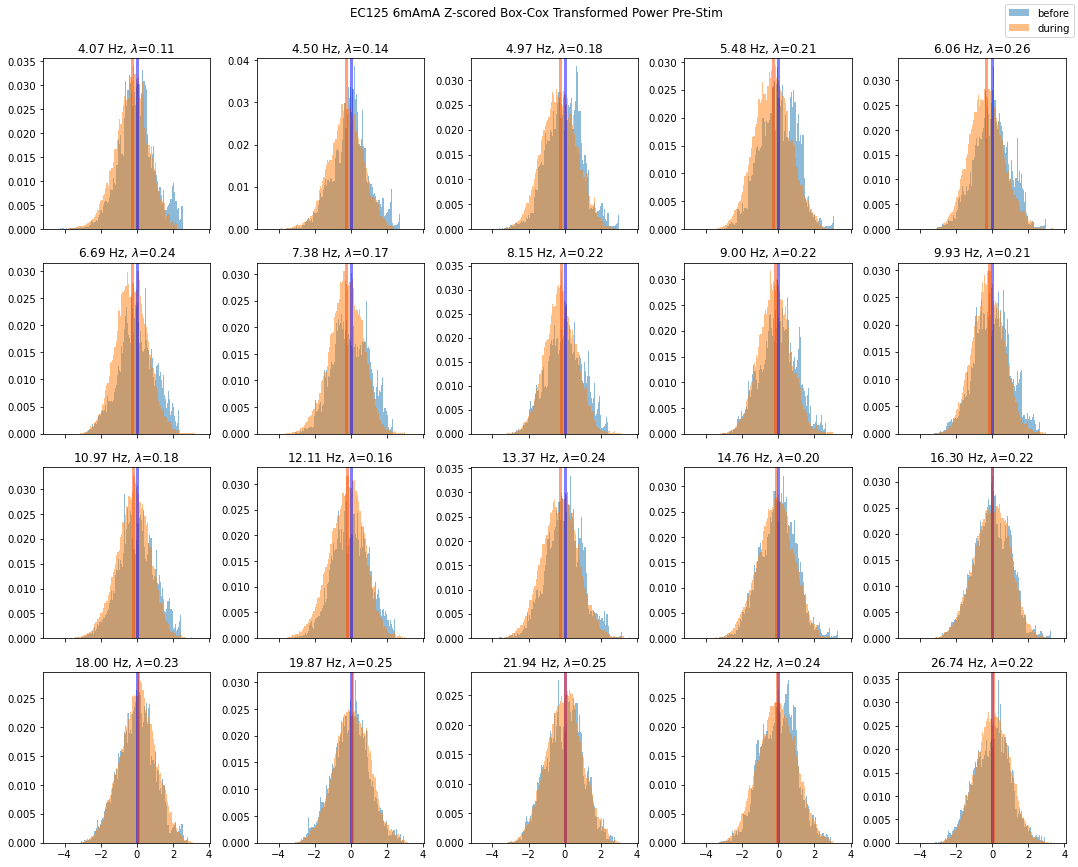

In [95]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharex=True)
before_stim = data[:stim_start].T
during_stim = data[stim_start:stim_end].T
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ind = i * 5 + j
        ax = axes[i, j]
        if ind > 20:
            fig.delaxes(ax)
            continue

        # bins = np.linspace(-3.0, 3.0, 100)
        bins = 100
        before_weight = np.ones_like(before_stim[ind]) / len(before_stim[ind])
        during_weight = np.ones_like(during_stim[ind]) / len(during_stim[ind])
        # after_weight = np.ones_like(after_stim[ind]) / len(after_stim[ind])

        alpha = 0.5
        weights = [before_weight]
        ax.hist(
            [before_stim[ind]],
            bins=bins,
            weights=weights,
            label=["before"],
            alpha=alpha,
        )

        ax.axvline(np.mean(before_stim[ind]), color="blue", lw=3, alpha=alpha)

        weights = [during_weight]
        ax.hist(
            [during_stim[ind]],
            bins=bins,
            weights=weights,
            label=["during"],
            alpha=alpha,
        )
        ax.axvline(np.mean(during_stim[ind]), color="orangered", lw=3, alpha=alpha)

        ax.set_title(rf"{freqs[ind]:.2f} Hz, $\lambda$={boxcox_lambda[ind]:.2f}")

handles, labels = axes[0, 0].get_legend_handles_labels()
remove_dupes = dict(zip(labels, handles))
fig.legend(remove_dupes.values(), remove_dupes.keys())
title = f"{patient} {current}mA Z-scored Box-Cox Transformed Power Pre-Stim {region}"
fig.suptitle(title, y=1.0)
fig.tight_layout()
title = title.replace(" ", "_")
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", dpi=300)

In [99]:
threshold = 4
drift = 2.5
upper_limit = 15
std = np.std(data[:stim_start], axis=0)
# mean = 0.5 * (np.mean(data[:stim_start], axis=0) + np.mean(data[stim_start:stim_end], axis=0)) # average the "good" and "bad" mean
mean = np.mean(data[:stim_start], axis=0)
S_upper_ind, S_lower_ind, S_upper, S_lower = cusum(
    data,
    threshold=threshold,
    parameter="mean",
    drift=drift,
    T_warmup=stim_start,
    zscore=False,
    std=std,
    mean=mean,
    cusum_type="limit",
    upper_limit=upper_limit,
)

In [100]:
len(S_upper_ind[0]), len(S_lower_ind[0])

(16711, 14542)

In [105]:
S_lower_ind

(array([   497,    498,    499, ..., 222914, 222915, 222916]),
 array([11, 11, 11, ...,  3,  3,  3]))

### Plot CUSUM

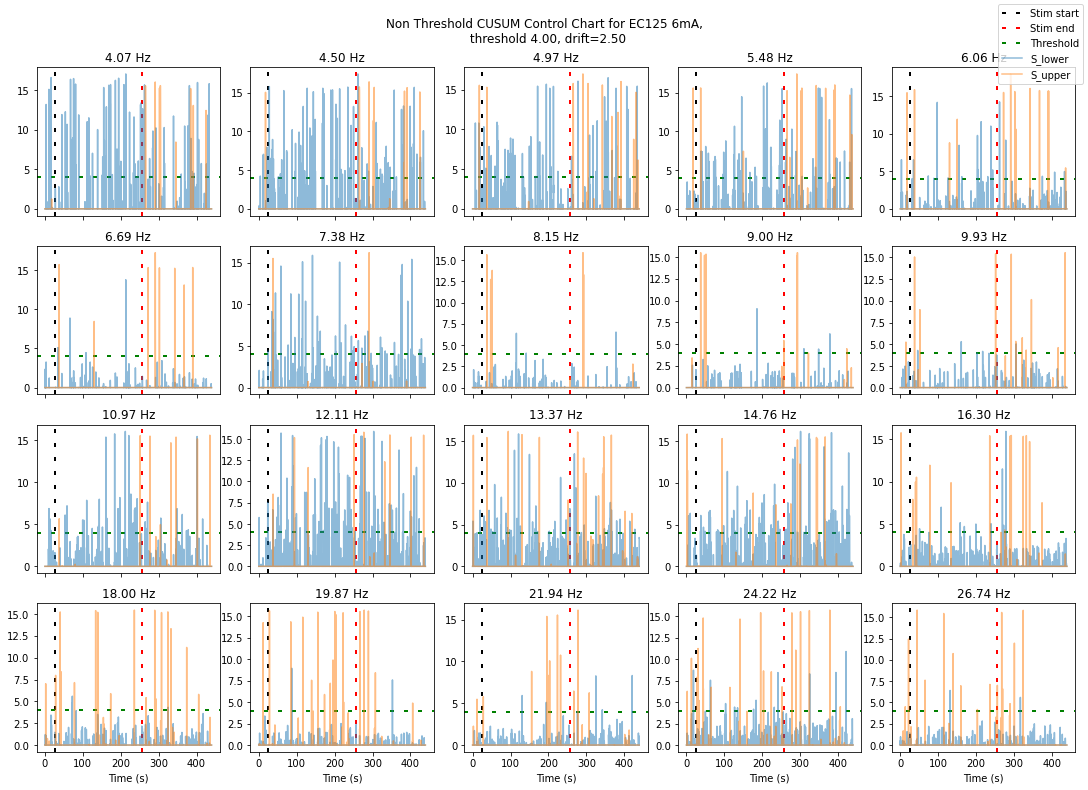

In [101]:
savefig = False
alpha = 0.5
linestyle = (0, (2, 5))
fig, axes = plt.subplots(4, 5, figsize=(15, 11), sharex=True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ind = i * 5 + j
        ax = axes[i, j]
        ax.axvline(
            stim_start / dsFs, linestyle=linestyle, color="k", lw=2, label="Stim start"
        )
        ax.axvline(
            stim_end / dsFs, linestyle=linestyle, color="red", lw=2, label="Stim end"
        )
        if np.max(np.abs((S_lower[:, ind], S_upper[:, ind]))) > threshold * std[ind]:
            ax.axhline(
                threshold * std[ind],
                linestyle=linestyle,
                color="green",
                lw=2,
                label="Threshold",
            )
        ax.plot(
            np.arange(len(S_lower)) / dsFs,
            np.abs(S_lower[:, ind]),
            alpha=alpha,
            label="S_lower",
        )
        ax.plot(
            np.arange(len(S_lower)) / dsFs,
            S_upper[:, ind],
            alpha=alpha,
            label="S_upper",
        )
        ax.set_title(f"{freqs[ind]:.2f} Hz")
        if i == len(axes) - 1:
            ax.set_xlabel("Time (s)")

handles, labels = axes[0, 0].get_legend_handles_labels()
remove_dupes = dict(zip(labels, handles))
fig.legend(remove_dupes.values(), remove_dupes.keys())
title = f"Non Threshold CUSUM Control Chart for EC125 6mA, \n threshold {threshold * std[ind]:.2f}, drift={drift * std[ind]:.2f}"
fig.suptitle(title)
fig.tight_layout()
title = title.replace(" ", "_").replace("\n", "").replace(",", "")

if savefig:
    plt.savefig(f"{IMG_DIR}/{title}.png", dpi=300)

### Plot CUSUM only at points where threshold is crossed

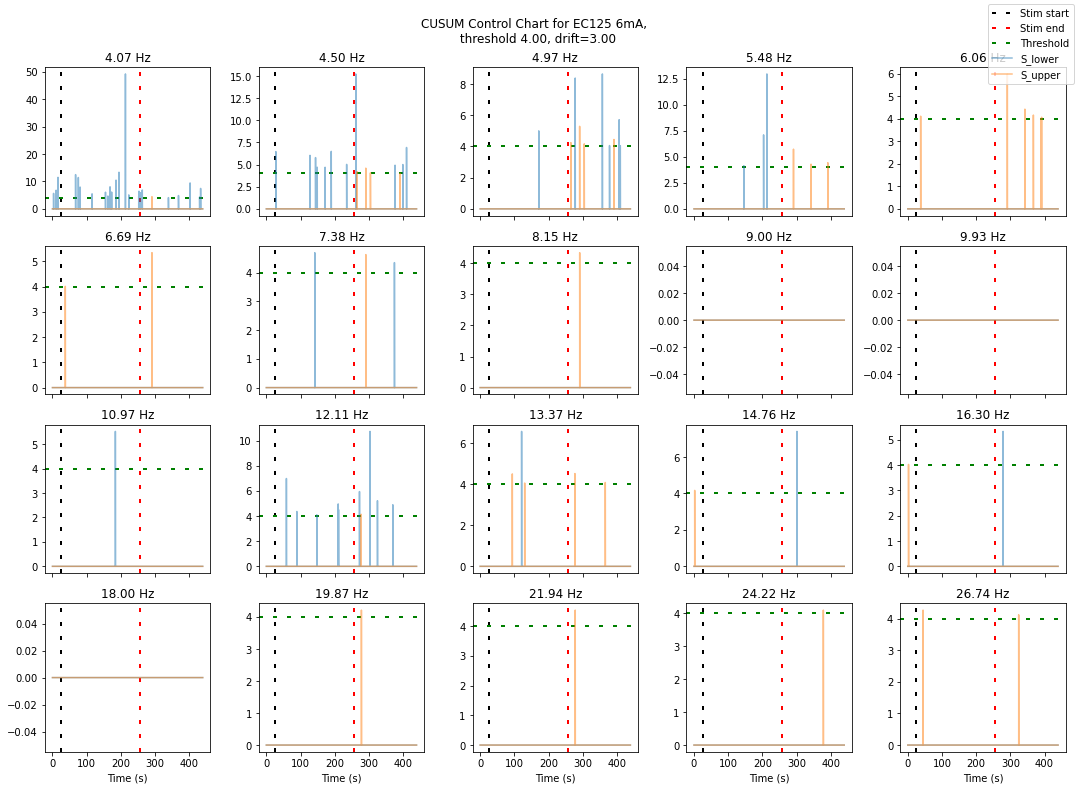

In [277]:
savefig = True
alpha = 0.5
threshold = 4
linestyle = (0, (2, 5))
fig, axes = plt.subplots(4, 5, figsize=(15, 11), sharex=True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ind = i * 5 + j
        ax = axes[i, j]
        ax.axvline(
            stim_start / dsFs, linestyle=linestyle, color="k", lw=2, label="Stim start"
        )
        ax.axvline(
            stim_end / dsFs, linestyle=linestyle, color="red", lw=2, label="Stim end"
        )
        if np.max(np.abs((S_lower[:, ind], S_upper[:, ind]))) > threshold * std[ind]:
            ax.axhline(
                threshold * std[ind],
                color="green",
                linestyle=linestyle,
                lw=2,
                label="Threshold",
            )
        ax.plot(
            np.arange(len(S_lower)) / dsFs,
            np.abs(
                np.where(S_lower[:, ind] < -threshold * std[ind], S_lower[:, ind], 0)
            ),
            alpha=alpha,
            label="S_lower",
        )
        ax.plot(
            np.arange(len(S_lower)) / dsFs,
            np.where(S_upper[:, ind] > threshold * std[ind], S_upper[:, ind], 0),
            alpha=alpha,
            label="S_upper",
        )
        ax.set_title(f"{freqs[ind]:.2f} Hz")
        if i == len(axes) - 1:
            ax.set_xlabel("Time (s)")

handles, labels = axes[0, 0].get_legend_handles_labels()
remove_dupes = dict(zip(labels, handles))
fig.legend(remove_dupes.values(), remove_dupes.keys())
title = f"CUSUM Control Chart for EC125 6mA, \n threshold {threshold * std[ind]:.2f}, drift={drift * std[ind]:.2f}"
fig.suptitle(title)
title = title.replace(" ", "_").replace("\n", "").replace(",", "")
fig.tight_layout()
if savefig:
    plt.savefig(f"{IMG_DIR}/{title}.png", dpi=300)

# Zoom in on one frequency band

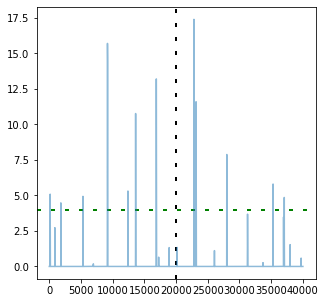

In [104]:
fig, ax = plt.subplots(figsize=(5, 5))
ind = 1
time_step = 20000

ax.axvline(time_step, linestyle=linestyle, color="k", lw=2, label="Stim start")
# ax.axvline(
#     stim_end + time_step, linestyle=linestyle, color="red", lw=2, label="Stim end"
# )
if np.max(np.abs((S_lower[:, ind], S_upper[:, ind]))) > threshold * std[ind]:
    ax.axhline(
        threshold * std[ind],
        linestyle=linestyle,
        color="green",
        lw=2,
        label="Threshold",
    )
ax.plot(
    # np.arange(len(S_lower)) / dsFs,
    np.abs(S_lower[stim_end - time_step : stim_end + time_step, ind]),
    alpha=alpha,
    label="S_lower",
)
# ax.plot(
#     np.arange(len(S_lower)) / dsFs,
#     S_upper[:, ind],
#     alpha=alpha,
#     label="S_upper",
# )

In [260]:
title

'CUSUM_Control_Chart_for_EC125_6mA__threshold_4.00'

In [108]:
l = [44.5, 46.1, 46.6]
np.mean(l)

45.73333333333333